In [1]:
%matplotlib notebook

# Time-Varying Matrix Eigenanalyses via Zhang Neural Networks and look-Ahead Finite Difference Equations
### von Frank Uhlig und Yunong Zhang

Ich versuche das hier [Link](https://arxiv.org/pdf/1904.10566.pdf) beschriebene Verfahren zu implementieren.

Dabei lasse ich zunächst sprunghaftes Verhalten der input-Funktion aus und versuche generell alles so einfach wie möglich zu halten.

### Formulierung des Problems

[Link zur PDF-Datei](http://webhome.auburn.edu/~uhligfd/m_files/ZNNpapers2019/contZDeigcomput2018.pdf)

Ziel ist es, Eigenwerte und eventuell auch Eigenvektoren einer parameterabhängigen Matrix $A(t)$ zu bestimmen, bzw. die Eigenkurven von einem Startpunkt aus zu verfolgen.

Mathematisch formuliert suchen wir für eine Matrix $A(t) \in \mathbb{C}^{n,n}$ alle Lösungen $\lambda(t) \in \mathbb{C}$ und $x(t) \in \mathbb{C}^n$, die für $t \in [t_{start},~t_{end}] \subseteq \mathbb{R}~ (\text{oder}~ \mathbb{C})$ die Gleichung

$$
\begin{equation}
    A(t)x(t)=\lambda(t)x(t) \iff A(t)x(t)-\lambda(t) I_n x(t)=0
\end{equation}
$$

lösen.

Wir wollen bei einer Lösung oder zumindest bei einer Approximation an die Lösung 
$(x(t),~\lambda(t))$ starten. Ausgehend davon, wollen wir eine Lösung an der Stelle $t_{next}=t+\tau$ berechnen, wobei mit $\tau$ die Schrittweite bezeichnet wird.

### Lösungsansatz


Der folgende Ansatz, der im Paper zunächst nur reelle Werte betrachtet, lautet:

Wir schätzen auf zunächst beliebige Weise einen nächsten Lösungsvektor. Dieser Vektor wird keine exakte Lösung sein, also definieren wir den zu minimierenden Fehler als
$$
\begin{equation}
    e(t):=A(t)x(t)-\lambda(t) I_n x(t)\overset{!}{=}0
\end{equation}
$$

Wir fordern eine exponentielle Verringerung des Fehlers durch
$~~
\begin{equation}
    \dot{e}(t)= -\eta e(t)
\end{equation}
~~$
mit $\eta > 0$.

Ableiten von $e$ liefert (vereinfacht ohne "$t$"):
$$
\begin{alignat}{1}
    &~\dot{A}x+A\dot{x}-\dot{\lambda} I_n x-\lambda I_n \dot{x} &~= &~-\eta (Ax-\lambda I_n x) \\
    \iff &~(A - \lambda I_n)\dot{x}-\dot{\lambda}x &~= &~~(-\eta(A-\lambda I_n)-\dot{A})x
\end{alignat}
$$

Die ducht einen Punkt gekennzeichneten Ableitungen sind immer Ableitungen bezüglich t, also $\dot{f}={\partial f}/{\partial t}$

Wir fügen noch die Bedingung $||x_i||=x_i^Tx_i=1$ hinzu, schreiben auch diese Gleichung als Fehler $e_2=x_i^Tx_i-1\overset{!}{=}0$ und erhalten analog zum Fehler $e$ die Gleichung
$$
\begin{equation}
   -x^T\dot{x}=\frac{\mu}{2}(x^Tx-1)
\end{equation}
$$
mit $\mu > 0$. Im folgenden sei $\eta = \mu$.

Schreibt man die letzten beiden Gleichungen zusammen als Matrizengleichung, erhält man
$$
\begin{equation}
    \begin{pmatrix}
        A-\lambda I_n & -x \\
        -x^T & 0
    \end{pmatrix}
    \begin{pmatrix}
        \dot{x}\\
        \dot{\lambda}
    \end{pmatrix}
    =
    \begin{pmatrix}
        (-\eta(A-\lambda I_n)-\dot{A})x \\
        \eta / 2 \cdot (x^Tx-1)
    \end{pmatrix}
\end{equation}
$$

Die Formulierung ist also sehr ähnlich zur "klassischen" Variante. Man kann also auch hier wieder ODE-Solver und PC-Verfahren benutzen.

Wir schätzen
$
\begin{equation}
    \dot{z} =
    \begin{pmatrix}
        \dot{x} \\
        \dot{\lambda}
    \end{pmatrix}
\end{equation}
$
mithilfe der [hier](https://ieeexplore.ieee.org/document/8314562) vorgestellten Formel
$$
\begin{equation}
    \dot{z}_k=\frac{13z_{k+1}-6z_{k}-2z_{k-1}-4z_{k-2}-3z_{k-3}+2z_{k-4}}{24\tau}
\end{equation},
$$

wobei $z_{k+1}$ der gesuchte nächste Lösungsvektor, $\dot{z}_{k}$ die letzte Lösung aus dem obigen Gleichungssystem und $z_{k-1},..,z_{k-4}$ vorherige Lösungen sind.

Die Matrixgleichung enthält noch die unbekannte Matrix $\dot{A}$, welche durch das Interpolationspolynom

$$
\begin{equation}
    \dot{A}_k=\frac{25A_k-48A_{k-1}+36A_{k-2}-16A_{k-3}+3A_{k-4}}{12\tau}
\end{equation}
$$
bestimmt wird.

Zu Beginn der Berechnung müssen also schon die ersten (hier 5) Lösungsvektoren $z_0,...,z_4$ und die Matrizen $A_0,...,A_4$ bekannt sein. Die ersten Lösungen berechne ich mit der Funktion `eig` aus `numpy`. Man kann erwarten (am Beispiel gezeigt), dass das Verfahren bei besseren Schätzungen der Ableitungen $\dot{z}$ und $\dot{A}$ präziser und stabiler ist. Interpolationspolynome höherer Ordnung sollten kein Problem darstellen und es sind auch andere Formeln für $\dot{z}$ bekannt. (Diese werden eventuell später noch implementiert.)

---

Ich übernehme folgende Bezeichnungen aus dem Paper. Untergestelltes $i$ kennzeichnet die $i$-te Eigenkurve.

$P(t_k) \in \mathbb{R}^{n+1,n+1}$ ist gegeben als:

$$
\begin{equation}
    P(t_k)=
    \begin{pmatrix}
        A(t_k)-\lambda_i(t_k)I_n & -x_i(t_k) \\
        -{x{_i}}^T(t_k) & 0
    \end{pmatrix}
\end{equation}
$$

$z(t_k) \in \mathbb{R}^{n+1}$ ist gegeben als:

$$
\begin{equation}
    z(t_k) =
    \begin{pmatrix}
        x_i(t_k) \\
        \lambda_i(t_k)
    \end{pmatrix}
\end{equation}
$$

$q(t_k) \in \mathbb{R}^{n+1}$ ist gegeben als:

$$
\begin{equation}
    q(t_k) =
    \begin{pmatrix}
        (-\eta(A(t_k)-\lambda_i(t_k)I_n)-\dot{A}(t_k))x_i(t_k) \\
        \eta / 2 \cdot ({x_i}^T(t)x_i(t)-1)
    \end{pmatrix}
\end{equation}
$$

Für $P(t_k)\dot{z}(t_k)=q(t_k)$ ist $\dot{z_k} = P \backslash q$, die Lösung des linearen Gleichungssystems $Px=q$

Diese Lösung kann oben für $\dot{z_k}$ eingesetzt werden und damit können wir den nächsten Vektor $z_{k+1}$ berechnen.

Um den Algorithmus zu starten, müssen die ersten (hier 5) Lösungen vorher bekannt sein. Darüm kümmert sich die folgende Funktion.

### Edit:
Für ein allgemeineres komplex-wertiges Verfahren habe ich den transponierten Vektor $x^T$ durch den adjungierten (komplex konjugierten und transponierten) Vektor $x^H$ ersetzt.

In [2]:
# %load tracking_funcs.py
from numpy.linalg import eig
from numpy import empty
from numpy import append as array_append
from numpy import eye
from numpy import array
from numpy import vstack
from numpy import dot
from numpy.linalg import solve
from numpy import vdot
from numpy import conj
import matplotlib.pyplot as plt
from numpy import iscomplex



def initial_solutions_complex(A_func, dim, t_start, tau, d=5, sort=False):
    """
    Returns all matrices A_func(t), its eigenvalues and eigenvecors for
    the first d values in time_vector.

    A_func must be a square-matrix-valued function with respect to one
    parameter.
    dim is the dimension of A_func
    t_start ist the starting value for the parameter
    the eigenvalue tracking algorithm
    tau ist the steplength in parameter tracking
    d is the number of solutions, this function has to generate
    """

    A = empty((dim, dim, d), dtype=complex)
    Z = empty((dim, dim+1, d), dtype=complex)

    for index in range(0, d):
        A[:, :, index] = A_func(t_start + index*tau)
        val, vec = eig(A[:, :, index])
        if sort: # works for last example, but breaks the others
            idx = val.argsort()
            val = val[idx]
            vec = vec[:,idx]
        Z[:, :-1, index] = vec.transpose()
        Z[:, -1, index] = val

    return A, Z




    # TODO substitute with more efficient routines
def set_Adot(d, tau):
    """Returns function that calculates Adot"""
    if d == 5:
        return lambda A, offset: (25*A[:, :, -1+offset] - 48*A[:, :, -2+offset] + 36*A[:, :, -3+offset]
                                  - 16*A[:, :, -4+offset] + 3*A[:, :, 0+offset]) / (12*tau)
    elif d == 6:
        return lambda A, offset: (137*A[:, :, -1+offset] - 300*A[:, :, -2+offset] + 300*A[:, :, -3+offset]
                                  - 200*A[:, :, -4+offset] + 75*A[:, :, -5+offset]
                                  - 12*A[:, :, 0+offset]) / (60*tau)
    else:
        raise NotImplementedError()




# TODO substitute with more efficient routines
def set_zdot(d):
    """Returns function that calculates Adot"""
    if d == 5:
        return lambda P, q, Zk, offset: ((solve(P, q)) + 6*Zk[:, -1+offset] + 2*Zk[:, -2+offset]
                                         + 4*Zk[:, -3+offset] + 3*Zk[:, -4+offset] - 2*Zk[:, 0+offset]) / 13
    elif d == 6:
        return lambda P, q, Zk, offset: ((solve(P, q)) - 80*Zk[:, -1+offset] + 182*Zk[:, -2+offset]
                                         + 206*Zk[:, -3+offset] - Zk[:, - 4+offset] - 110*Zk[:, -5+offset]
                                         + 40*Zk[:, 0+offset]) / 237
    else:
        raise NotImplementedError()




def set_tau_coeff(d):
    # e.g. calculatet from TPOLY = 1 80/237 -182/237 -206/237 1/237 110/237 -40/237 0 0.0000 446/465 196/79
    # values generated for  7-IFD finite difference method
    # tau_coef is calculated by gcd(denominators)(=237 in this case) times last values (=196/79)
    # in general cases floar values are given thus we wont divide solve(P, q) by gcd(denominators)
    # then the last values is the coefficient for tau
    # !! for now negative polynom coeffs were used so tau coeffs are negative (opposite sign)
    coeffs = {5: -24, 6: -588}
    return coeffs[d]




def eigenvalue_tracking_complex(A_func, dim=None, t_start=0, t_end=1, tau=0.001, eta=4.5, d=5, sort=False):
    """
    Returns computed eigenvalues

    A_func is the parameter-dependent matrix whose eigenvalues we track
    t_start is the parameter starting value
    t_end is the parameters upper bound
    tau ist the step size / the increment of the parameter
    eta is a decay constant
    d is the number of exact start solutions (only d=5,6 implemented)
    """

    if d not in [5, 6]:  # manually add implemented orders if implemented
        raise NotImplementedError()

    if dim is None:
        dim = A_func(t_start).shape[0]

    iteration = 0  # iteration number is the step to compute next

    # set Adot function
    Adot_func = set_Adot(d, tau)

    # set zdot function
    zdot_func = set_zdot(d)

    # set tau coefficient
    tau_coeff = set_tau_coeff(d)
    coeff = tau_coeff*tau

    # init P and q
    P = empty((dim+1, dim+1), dtype=complex)
    q = empty(dim+1, dtype=complex)

    # calculate fist 'exact' solutions (with numpy eig)
    A, Z = initial_solutions_complex(
        A_func=A_func, dim=dim, t_start=t_start, tau=tau, d=d, sort=sort)

    time = array(t_start, ndmin=2)
    eigenvalues = array(Z[:, -1, 0], copy=True)

    iteration += d  # calculate k=d next
    t = t_start + iteration*tau

    while t < t_end:

        # use offset to overwrite no longer needed values with the new values
        offset = iteration % d

        # calculate Adot
        Adot = Adot_func(A, offset)

        for k in range(dim):  # calculate next solution z for each eigencurve

            # just for easy first code
            xk = Z[k, :-1, -1+offset]  # most recent eigenvector
            lamk = Z[k, -1, -1+offset] # most recent eigenvalue

            # calculate A-lambda*I (used 2 times)
            Al = A[:, :, -1+offset] - lamk*eye(dim)

            # construct matrix P (defined in markdown above)
            P[:-1,:-1] = Al
            P[:-1,-1] = -xk
            P[-1,:-1] = -conj(xk)
            P[-1,-1] = 0

            # construct vector q (defined in markdown above)
            q[:-1] = dot(eta*Al + Adot, xk)
            q[-1] = -eta/2*(vdot(xk, xk)-1)
            q *= coeff

            # calculate new solution vector
            z_next = zdot_func(P, q, Z[k, :, :], offset)

            # overwrite old solution vector
            Z[k, :, 0+offset] = z_next

        # generate new A(t) for current (new) t
        # overwrites oldest A(t)
        A[:, :, 0+offset] = A_func(t)

        #if offset == 0:  # only save every "d-th" solution
        time = array_append(time, t)
        eigenvalues = vstack((eigenvalues, Z[:, -1, -1]))

        iteration += 1
        t += tau

    return time, eigenvalues




def plot_1(time, eigenvalues):
    plt.figure(figsize=(16, 9), dpi=60)
    ax = plt.axes()
    ax.plot(time, eigenvalues)
    ax.set_xlabel(r'$t$', fontsize=20)
    plt.title(r"alle Eigenwerte von $A$ in Abhängigkeit von $t$", fontsize=20)
    plt.show()
    return




def plot_2(time, eigenvalues):
    plt.figure(figsize=(16, 9), dpi=60)
    ax = plt.axes()
    ax.plot(time, eigenvalues.real)
    ax.set_xlabel(r'$t$', fontsize=20)
    plt.title(r"alle Eigenwerte von $A$ in Abhängigkeit von $t$", fontsize=20)
    plt.show()

    plt.figure(figsize=(16, 9), dpi=60)
    ax = plt.axes()
    ax.plot(time, eigenvalues.imag)
    ax.set_xlabel(r'$t$', fontsize=20)
    plt.title(r"alle Eigenwerte von $A$ in Abhängigkeit von $t$", fontsize=20)
    plt.show()
    return




def plot_3(time, eigenvalues):
    """Plot real or complex eigenvalues"""
    #check if eigenvalues are real or complex
    eigs_complex = iscomplex(eigenvalues).any()

    #both cases plot real part
    plt.figure(figsize=(16, 9), dpi=60)
    ax = plt.axes()
    ax.plot(time, eigenvalues.real)
    ax.set_xlabel(r'$t$', fontsize=20)
    if eigs_complex:
        plt.title(r"$\Re(EW)$ von $A$ in Abhängigkeit von $t$", fontsize=20)
    else:
        plt.title(r"Eigenwerte von $A$ in Abhängigkeit von $t$", fontsize=20)
    plt.show()

    if eigs_complex:
        plt.figure(figsize=(16, 9), dpi=60)
        ax = plt.axes()
        ax.plot(time, eigenvalues.imag)
        ax.set_xlabel(r'$t$', fontsize=20)
        plt.title(r"$\Im(EW)$ von $A$ in Abhängigkeit von $t$", fontsize=20)
        plt.show()
    return




def plot_4(time, eigenvalues):
    fig = plt.figure(figsize=(16, 16), dpi=60)
    ax = fig.gca(projection='3d')
    for i in range(eigenvalues.shape[1]):
        ax.plot(time, eigenvalues.real[:, i], eigenvalues.imag[:, i])
    ax.set_xlabel(r'$t$', fontsize=20)
    ax.set_ylabel(r'$\Re(EW)$', fontsize=20)
    ax.set_zlabel(r'$\Im(EW)$', fontsize=20)
    plt.title(r"alle Eigenwerte von $A$ in Abhängigkeit von $t$", fontsize=20)
    plt.show()
    return


In [3]:
from numpy import exp
from numpy import sin
from numpy import cos
from numpy import arctan
from numpy import array

In [4]:
# define small test matrices

# example function from http://webhome.auburn.edu/~uhligfd/m_files/T-VMatrixEigenv/inputeigsinglewjumps2.m
#vlt symbolische lösung
def testmatrix_A_5():
    return lambda t: array([
        [sin(t) + 2, exp(sin(t)), -exp(sin(t)), 1 / 2, 1 + cos(t)],
        [exp(sin(t)), cos(t) - 2, 1, cos(2 * t), 1],
        [-exp(sin(t)), 1, 1 / (t + 1), arctan(t), sin(2 * t)],
        [1 / 2, cos(2 * t), arctan(t), 1, exp(cos(t))],
        [1 + cos(t), 1, sin(2 * t), exp(cos(t)), 1 / (t + 2)]
    ])


def testmatrix_A_7():
    return lambda t: array([
        [(t-16)*sin(t)+2j, exp(sin(t)), 1.2*1j*t, -exp(sin(t)), 1j/2, 1j+cos(t), 0],
        [exp(sin(2*t)), cos(t)-2j, 2j, 1j, cos(2*t), 1, 0],
        [1j*t, 0, -0.12*t**2+2.4*t-7, 0, 0, 0, 6j-5],
        [-1j*exp(sin(t)), -2j, 0, 1/(t+1j), arctan(11*t), sin(2*t)*2j+6j, 0],
        [1/2, cos(2*t), 1j*sin(t), arctan(t), 1, exp(cos(t)), 0],
        [1+2j*cos(t), 1, 0, sin(2*t), exp(cos(t)), 1j/(t+2), 0],
        [0, t-3j, 2j, 0, 0, 0, -0.15*t**2*1j+3*t-6]
    ])


def matrix_A_plus_tB(A: array, B: array):
    # test dim/shape
    assert A.shape == B.shape, "Matrices A and B must have the same shape."
    assert A.shape[0] == A.shape[1], "Matrices A and B are expected to be square."
    return lambda t: A + t * B

In [5]:
from numpy import zeros
from numpy import block

In [6]:
# try to reconstruct fig 6: http://webhome.auburn.edu/~uhligfd/m_files/ZNNpapers2019/Coalescing%20Evalues.pdf
# and similar n-dim matrices
def testmatrix_A_14():
    A7 = testmatrix_A_7()
    return lambda t: block([[A7(t), zeros((7, 7))],
                            [zeros((7, 7)), 2*A7(t)]])

#generelise testmatrix_A_14()
def testmatrix_A_n(n, B=testmatrix_A_7(), B_dim=7):

    def new_diag_block(An, dim, factor):
        return lambda t: block([[An(t), zeros((dim, B_dim))],
                                [zeros((B_dim, dim)), factor*B(t)]])

    # how often do i create new 7x7 diagonal blocks
    iters = n//B_dim + (n % B_dim > 0)
    An = B
    A_dim = B_dim
    iters -= 1
    for i in range(iters):
        # new block with factor i+1 = 2,3,4,..
        An = new_diag_block(An, A_dim, i+2)
        A_dim += B_dim

    # An is now a square B_dim*m dimensional matrix with
    # B_dim*(m-1) < n <= B_dim*m
    # An needs to be sliced to square n dimensional matrix
    return lambda t: An(t)[:n, :n]

In [7]:
from numpy import random
from numpy import ones

In [8]:
# define larger test matrices
def square_test_matrix(seed: int = 42, size: int = 20, low: int = -10, high: int = 10):
    """Returns intager valued ([low,high]) sizexsize matrix"""
    random.seed(seed)
    return random.randint(low=low, high=high, size=(size, size))


# define parameter dependent matrix as homotopy
def square_simple_homotopy_matrix(A, B=None):
    """
    Returns simple homotopy H(alpha)= A-alpha*B
    B is I by default if no B is given
    """
    if B is None:
        return lambda alpha: A - alpha*eye(A.shape[0])
    else:
        return lambda alpha: A - alpha*B


# define a generic symmetric test matrix
def test_mat(size: int = 20):
    A = square_test_matrix(seed=432, size=size, low=-2, high=2)
    return dot(A, A.T)

<IPython.core.display.Javascript object>


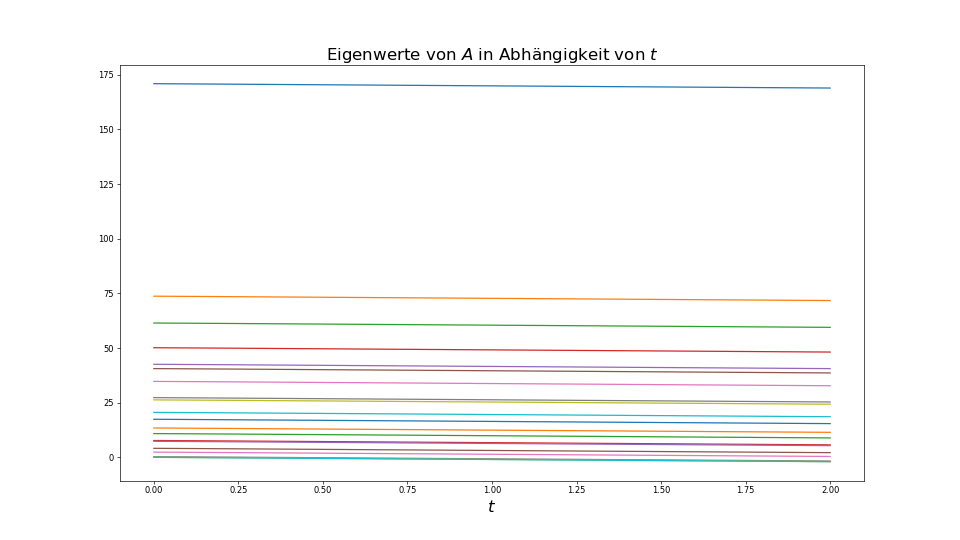

In [44]:
A2 = test_mat()
A_func = square_simple_homotopy_matrix(A2)

time, eigenvalues = eigenvalue_tracking_complex(A_func, t_end=2, tau=0.005, eta=4.5)
plot_3(time, eigenvalues)

In [45]:
# define very small test matrix
def A_func(t): return array([[1, t], [t*t, 1]], dtype=complex)

<IPython.core.display.Javascript object>


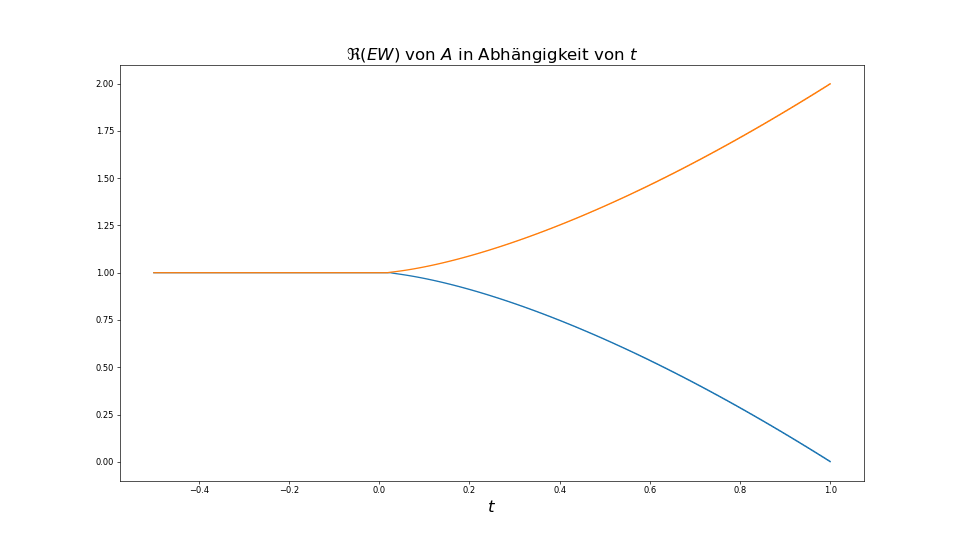

<IPython.core.display.Javascript object>


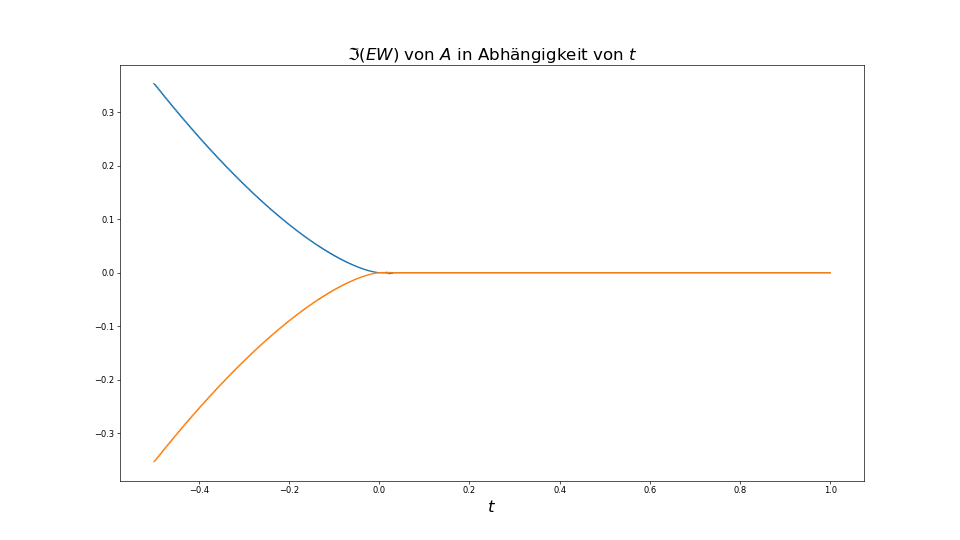

In [46]:
# used smaller increment and changed eta to get good results
# A_func, t_start=-0.5, t_end=3, tau=0.0005, eta=5.0, d=5
time, eigenvalues = eigenvalue_tracking_complex(
    A_func, t_start=-0.5, t_end=1, tau=0.0005, eta=5.0, d=5)
plot_3(time, eigenvalues)
#plot_4(time, eigenvalues)

# if t_start is set to -2, the algorithm will break (follows same curve instead of splitting)
# this problem is described in http://webhome.auburn.edu/~uhligfd/m_files/ZNNpapers2019/Coalescing%20Evalues.pdf
# on page 13-14
# try "t_start=-2, t_end=1, tau=0.001, eta=1.0" in that case

# for d=6 try: (very tricky to pick right eta)
# A_func, t_start=-0.5, t_end=1, tau=0.0001, eta=0.7, d=6

# Ausblick:

Am letzten Plot sieht man, dass das Verfahren noch nicht perfekt ist. Wie schon in dem Paper vorgeschlagen, sollte man an kritischen Stellen (Paper: dort wo die Norm von $\dot{A}$ sehr groß wird) das Verfahren neu starten oder eine geeignete Behandlung implementieren.

Es wurde zudem vorgeschlagen, dass "fast-Berührstellen" und Überschneidungen erfasst und später ausgegeben werden. Auch dafür gibt es schon passenden Matlab-Code.

Offensichtlich lässt sich das Verfahren noch optimieren. Zum Einen beinhaltet der Code noch überflüssige Rechenoperationen, die zur Fehlerbehandlung und leichteren Implementierung dienten. Außerdem werden die Lösungen $z_k$ noch einzelnd berechnet. Hier kann man sich zumindest einige Rechnungen und vor allem Kopiervorgänge sparen.

Für sehr große Matrizen ist es sicherlich nicht sinnvoll, alle Eigenwerte zu verfolgen. Es sollte nicht allzu kompliziert sein, die Funktion so anzupassen, dass nur z.B anfangs ausgewählte Eigenwerte verfolgt werden.

Im Folgenden noch einige weitere Beispiele:

<IPython.core.display.Javascript object>


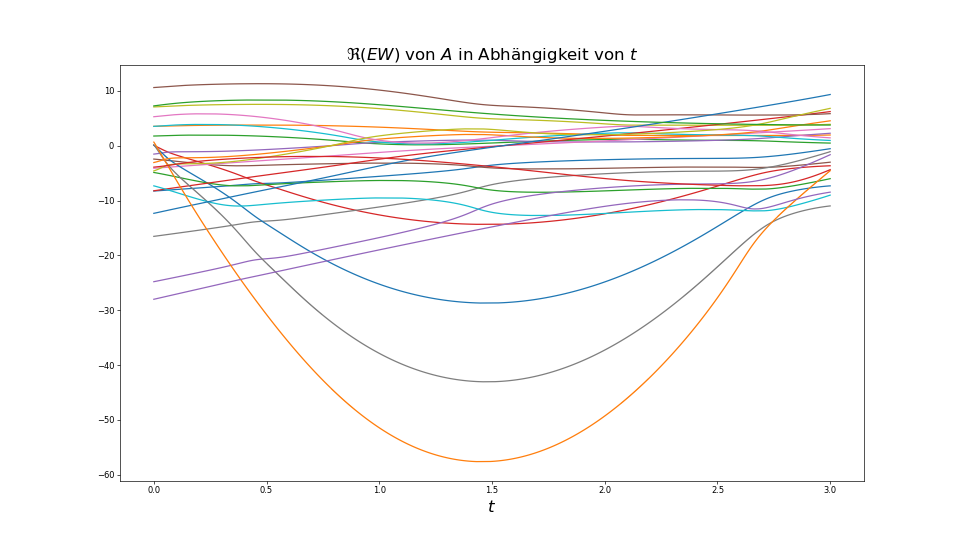

<IPython.core.display.Javascript object>


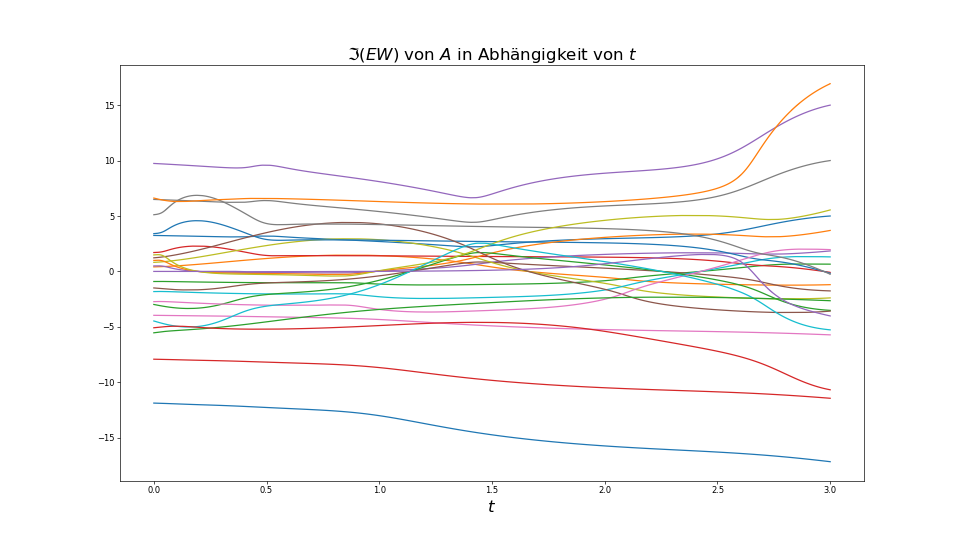

<IPython.core.display.Javascript object>


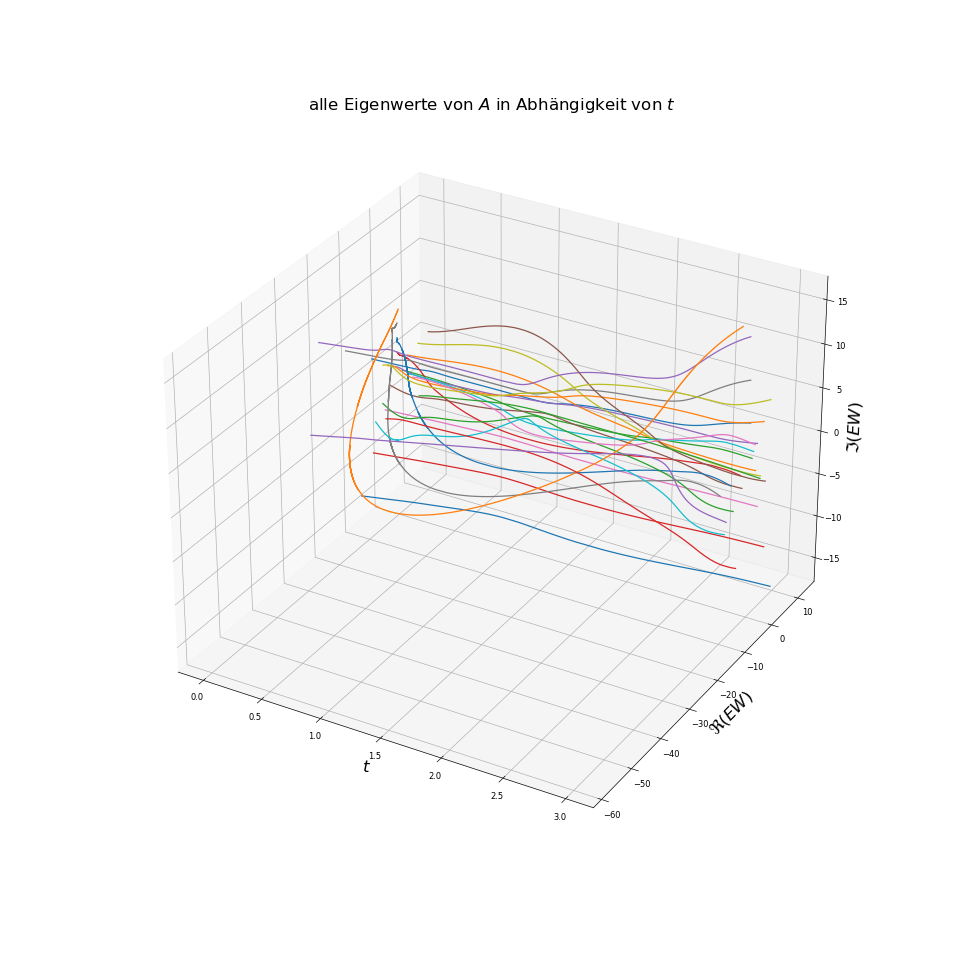

In [47]:
# set dim for test matrix
dim = 25

time, eigenvalues = eigenvalue_tracking_complex(
    A_func=testmatrix_A_n(dim), dim=dim, t_start=0, t_end=3, tau=0.0001, eta=4.5, d=6)

plot_3(time, eigenvalues)
plot_4(time, eigenvalues)

In [48]:
from numpy import sqrt

<IPython.core.display.Javascript object>


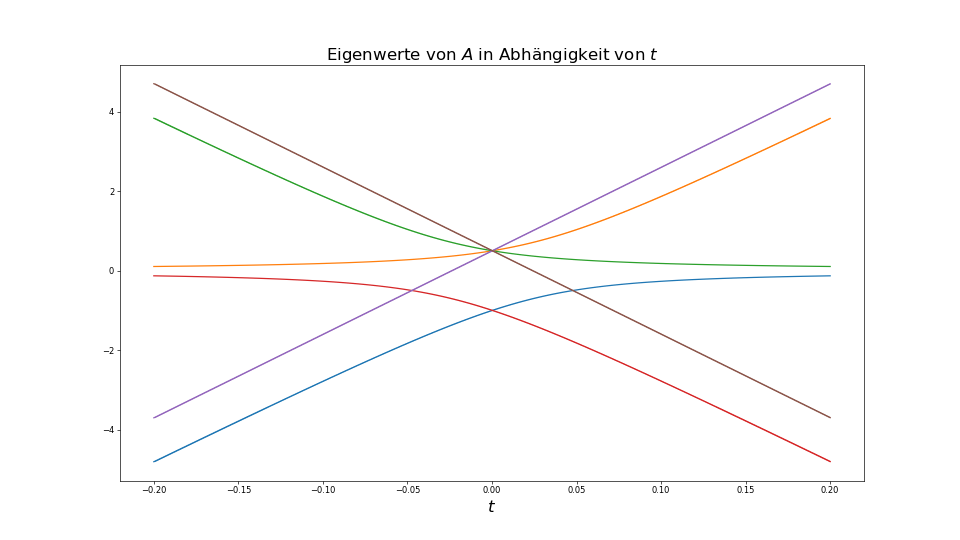

In [49]:
sq = sqrt(2)

# example from https://mathematica.stackexchange.com/questions/165167/tracking-eigenvalues-through-a-crossing
def testmatrix_H_6():
    sq = sqrt(2)
    return lambda t: array([
        [1/2 + 21*t, 0, 0, 0, 0, 0],
        [0, 1/2 + 7*t, 0, 0, 7*sq*t, 0],
        [0, 0, 1/2 - 7*t, 0, 0, 7*sq*t],
        [0, 0, 0, 1/2 - 21*t, 0, 0],
        [0, 7*sq*t, 0, 0, -1 + 14*t, 0],
        [0, 0, 7*sq*t, 0, 0, -1 - 14*t]
    ])


A_func = testmatrix_H_6()

time, eigenvalues = eigenvalue_tracking_complex(
    A_func, dim=6, t_start=-.2, t_end=.2, tau=0.0001, eta=4.5, d=5)
plot_3(time, eigenvalues)

Wie in obiger Grafik gut zu erkennen, funktioniert das Verfahren auch bei schwierig aussehenden Kreuzungen.

---

Ich versuche zuletzt, das Verfahren auf das SIDARTHE-System anzuwenden.

In [11]:
import sympy as sp

In [12]:
# define symbols for both systems

S_1 = sp.symbols('S_1')
alpha_1 = sp.symbols('alpha_1')
beta_1 = sp.symbols('beta_1')
gamma_1 = sp.symbols('gamma_1')
epsilon_1 = sp.symbols('epsilon_1')
zeta_1 = sp.symbols('zeta_1')
lambda_1 = sp.symbols('lambda_1')
theta_1 = sp.symbols('theta_1')
mu_1 = sp.symbols('mu_1')
kappa_1 = sp.symbols('kappa_1')
sigma_1 = sp.symbols('sigma_1')
tau_1 = sp.symbols('tau_1')

S_2 = sp.symbols('S_2')
alpha_2 = sp.symbols('alpha_2')
beta_2 = sp.symbols('beta_2')
epsilon_2 = sp.symbols('epsilon_2')
zeta_2 = sp.symbols('zeta_2')
lambda_2 = sp.symbols('lambda_2')
theta_2 = sp.symbols('theta_2')
mu_2 = sp.symbols('mu_2')
kappa_2 = sp.symbols('kappa_2')
sigma_2 = sp.symbols('sigma_2')
tau_2 = sp.symbols('tau_2')

pi_1 = sp.symbols("pi_1")
pi_2 = sp.symbols("pi_2")

In [13]:
sp.Matrix([[alpha_1*S_1-(epsilon_1+zeta_1+lambda_1), beta_1*S_1, alpha_1*S_1, beta_1*S_1, pi_2 * S_1,  0, 0, 0],
            [epsilon_1, -(zeta_1+lambda_1), 0, 0, 0, 0, 0, 0],
            [zeta_1, 0, -(theta_1+mu_1+kappa_1), 0, 0, 0, 0, 0],
            [0, zeta_1, theta_1, -(mu_1+kappa_1), 0, 0, 0, 0],
            [pi_1 * S_2, 0, 0, 0, alpha_2*S_2-(epsilon_2+zeta_2+lambda_2), beta_2*S_2, alpha_2*S_2, beta_1*S_2],
            [0, 0, 0, 0, epsilon_2, -(zeta_2+lambda_2), 0, 0],
            [0, 0, 0, 0, zeta_2, 0, -(theta_2+mu_1+kappa_2), 0],
            [0, 0, 0, 0, 0, zeta_2, theta_2, -(mu_2+kappa_2)]
           ])

Matrix([
[S_1*alpha_1 - epsilon_1 - lambda_1 - zeta_1,         S_1*beta_1,               S_1*alpha_1,      S_1*beta_1,                                    S_1*pi_2,                  0,                         0,               0],
[                                  epsilon_1, -lambda_1 - zeta_1,                         0,               0,                                           0,                  0,                         0,               0],
[                                     zeta_1,                  0, -kappa_1 - mu_1 - theta_1,               0,                                           0,                  0,                         0,               0],
[                                          0,             zeta_1,                   theta_1, -kappa_1 - mu_1,                                           0,                  0,                         0,               0],
[                                   S_2*pi_1,                  0,                         0,               0, S

In [14]:
from collection import Parameters8

In [15]:
# define parameters
p = Parameters8()

S_1 = 0.9
S_2 = 0.9
alpha_1 = 0.3
alpha_2 = 0.4

beta_1 = p.beta
epsilon_1 = p.epsilon
zeta_1 = p.zeta
lambda_1 = p.my_lambda
theta_1 = p.theta
mu_1 = p.mu
kappa_1 = p.kappa
sigma_1 = p.sigma
tau_1 = p.tau

beta_2 = 1.1*p.beta
epsilon_2 = 1.1*p.epsilon
zeta_2 = 1.1*p.zeta
lambda_2 = 1.1*p.my_lambda
theta_2 = 1.1*p.theta
mu_2 = 1.1*p.mu
kappa_2 = 1.1*p.kappa
sigma_2 = 1.1*p.sigma
tau_2 = 1.1*p.tau

In [16]:
def testmatrix_SIDARTHE_const_pi1(pi_1):
    return lambda pi_2: array([
            [alpha_1*S_1-(epsilon_1+zeta_1+lambda_1), beta_1*S_1, alpha_1*S_1, beta_1*S_1, pi_2 * S_1,  0, 0, 0],
            [epsilon_1, -(zeta_1+lambda_1), 0, 0, 0, 0, 0, 0],
            [zeta_1, 0, -(theta_1+mu_1+kappa_1), 0, 0, 0, 0, 0],
            [0, zeta_1, theta_1, -(mu_1+kappa_1), 0, 0, 0, 0],
            [pi_1 * S_2, 0, 0, 0, alpha_2*S_2-(epsilon_2+zeta_2+lambda_2), beta_2*S_2, alpha_2*S_2, beta_1*S_2],
            [0, 0, 0, 0, epsilon_2, -(zeta_2+lambda_2), 0, 0],
            [0, 0, 0, 0, zeta_2, 0, -(theta_2+mu_1+kappa_2), 0],
            [0, 0, 0, 0, 0, zeta_2, theta_2, -(mu_2+kappa_2)]
           ])

def testmatrix_SIDARTHE_const_pi2(pi_2):
    return lambda pi_1: array([
            [alpha_1*S_1-(epsilon_1+zeta_1+lambda_1), beta_1*S_1, alpha_1*S_1, beta_1*S_1, pi_2*S_1,  0, 0, 0],
            [epsilon_1, -(zeta_1+lambda_1), 0, 0, 0, 0, 0, 0],
            [zeta_1, 0, -(theta_1+mu_1+kappa_1), 0, 0, 0, 0, 0],
            [0, zeta_1, theta_1, -(mu_1+kappa_1), 0, 0, 0, 0],
            [pi_1 * S_2, 0, 0, 0, alpha_2*S_2-(epsilon_2+zeta_2+lambda_2), beta_2*S_2, alpha_2*S_2, beta_1*S_2],
            [0, 0, 0, 0, epsilon_2, -(zeta_2+lambda_2), 0, 0],
            [0, 0, 0, 0, zeta_2, 0, -(theta_2+mu_1+kappa_2), 0],
            [0, 0, 0, 0, 0, zeta_2, theta_2, -(mu_2+kappa_2)]
           ])

<IPython.core.display.Javascript object>


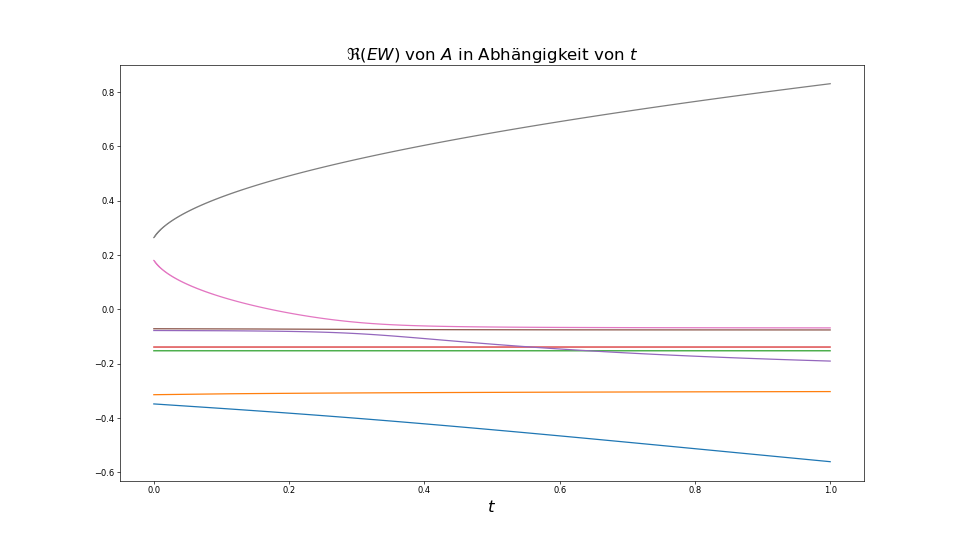

<IPython.core.display.Javascript object>


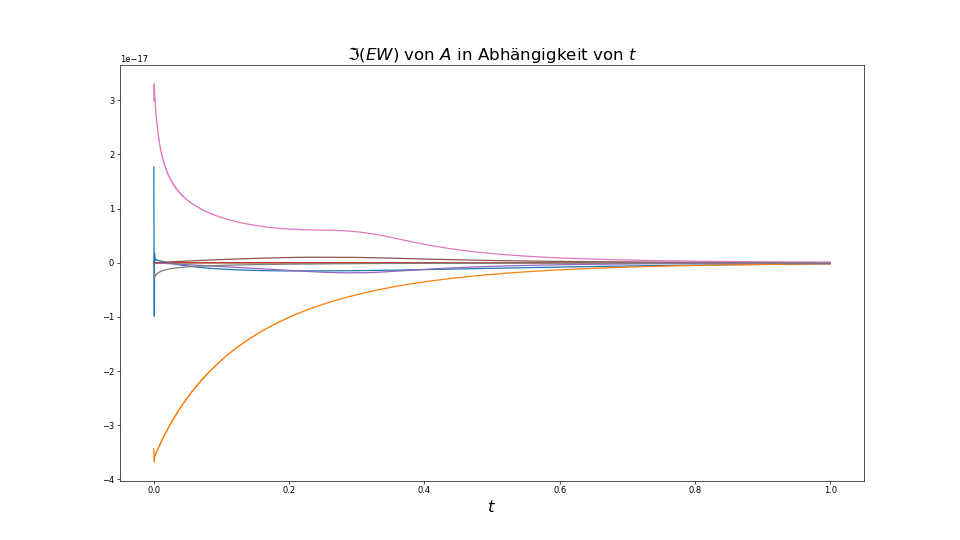

In [17]:
A_func = testmatrix_SIDARTHE_const_pi1(0.5)

time, eigenvalues = eigenvalue_tracking_complex(
    A_func, t_start=0., t_end=1, tau=0.0001, eta=4.5, d=5, sort=True)
plot_3(time, eigenvalues)